# 📓 Qdislib Example Notebook

This document explains each section of the Qdislib Jupyter notebook, showcasing how to apply gate and wire cutting techniques to large quantum circuits using Qdislib, Qibo, Qiskit, and PyCOMPSs.

Import the PyCOMPSs library

In [1]:
import pycompss.interactive as ipycompss

### 🔧 1. Environment Setup with PyCOMPSs

Goal: Start the PyCOMPSs runtime for distributed execution.

What Happens:

* Loads required COMPSs XML config files: project.xml and resources.xml.

* Enables optional flags like graph, monitor, debug, and trace.

Why: PyCOMPSs enables parallel task execution — crucial for evaluating subcircuits in distributed environments.

In [2]:
ipycompss.start(graph=True, monitor=1000)  # debug=True, trace=True

********************************************************
**************** PyCOMPSs Interactive ******************
********************************************************
*          .-~~-.--.           ______         ______   *
*         :         )         |____  \       |____  \  *
*   .~ ~ -.\       /.- ~~ .      __) |          __) |  *
*   >       `.   .'       <     |__  |         |__  |  *
*  (         .- -.         )   ____) |   _    ____) |  *
*   `- -.-~  `- -'  ~-.- -'   |______/  |_|  |______/  *
*     (        :        )           _ _ .-:            *
*      ~--.    :    .--~        .-~  .-~  }            *
*          ~-.-^-.-~ \_      .~  .-~   .~              *
*                   \ \ '     \ '_ _ -~                *
*                    \`.\`.    //                      *
*           . - ~ ~-.__\`.\`-.//                       *
*       .-~   . - ~  }~ ~ ~-.~-.                       *
*     .' .-~      .-~       :/~-.~-./:                 *
*    /_~_ _ . - ~              

* - Log path : /home/mbjar/.COMPSs/Interactive_01/
* - PyCOMPSs Runtime started... Have fun!              *
********************************************************


Import task and compss_wait_on module before annotating functions or methods

In [3]:
from pycompss.api.task import task
from pycompss.api.api import compss_wait_on

### 🧠 2. Importing Required Modules

Modules:

* qibo.models, qibo.gates, qibo.hamiltonians: for defining and manipulating quantum circuits.

* qd: likely refers to Qdislib, which contains the circuit cutting functions.

Setup:

* Sets the backend for Qibo ("numpy") to run locally on CPU.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import qibo
from qibo import models, gates, hamiltonians, callbacks
from qibo.models import Circuit
from qibo.symbols import X, Y, Z, I
from qibo.ui import plot_circuit

qibo.__version__
qibo.set_backend("numpy")

[Qibo 0.2.18|INFO|2025-05-07 17:11:18]: Using numpy backend on /CPU:0


Import Qdislib where the circuit cutting is implemented

In [5]:
import Qdislib.api as qd

### ⚙️ 3. Define the Main Circuit

Function entire_circuit(): builds a 10-qubit circuit with:

* Single-qubit gates: H, RX, RY, RZ.

* Two-qubit gates: CZ.

Circuit Objective: Simulates a non-trivial entangled circuit useful for demonstrating cutting algorithms.

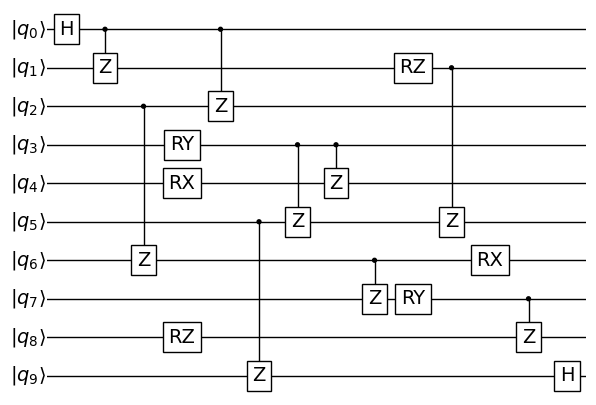

In [6]:
def entire_circuit():
    nqubits = 10
    circuit = models.Circuit(nqubits)

    circuit.add(gates.H(0))
    circuit.add(gates.CZ(0, 1))
    circuit.add(gates.CZ(2, 6))
    circuit.add(gates.RZ(8, np.pi / 3))

    circuit.add(gates.RY(3, np.pi / 5))
    circuit.add(gates.RX(4, np.pi / 5))
    circuit.add(gates.CZ(0, 2))
    circuit.add(gates.CZ(5, 9))

    circuit.add(gates.CZ(3, 5))
    circuit.add(gates.CZ(3, 4))
    circuit.add(gates.CZ(6, 7))
    circuit.add(gates.RY(7, np.pi / 5))
    circuit.add(gates.RZ(1, np.pi / 5))

    circuit.add(gates.CZ(1, 5))
    circuit.add(gates.RX(6, np.pi / 5))
    circuit.add(gates.CZ(7, 8))

    circuit.add(gates.H(9))
    return circuit


circuit = entire_circuit()
# print(circuit.draw())
plot_circuit(circuit, scale=0.5);

### ✂️ 4. Gate Cutting Example

qd.find_cut(circuit): Automatically identifies gates suitable for cutting.

* Example result: ['CZ_2']


qd.gate_cutting(circuit, cut):

* Applies the gate cutting algorithm.

* Cuts the circuit at the specified gate.

* Evaluates subcircuits and reconstructs the expectation value.

* Output: A reconstructed value (e.g., 0.0084...).

In [7]:
circuit = entire_circuit()

cut = qd.find_cut(circuit)
print(cut)

['CZ_2']


In [8]:
reconstruction = qd.gate_cutting(circuit, cut)
print(reconstruction)

-0.0057811737060546875


### 🔌 5. Wire Cutting Example

find_cut(..., gate_cut=False):

* Finds cuts (pairs of gates) between which a wire cut is possible.

* Force the algorithm to only finde wire cuts (setting gate_cut=False)

* Example: [('CZ_2', 'CZ_7')]

qd.wire_cutting(...):

* Applies the wire cutting method across the selected gates.

* Calculates the reconstructed expectation value.

In [9]:
circuit = entire_circuit()

cut = qd.find_cut(circuit, gate_cut=False)
print(cut)

[('CZ_2', 'CZ_7')]


In [10]:
reconstruction = qd.wire_cutting(circuit, cut)
print(reconstruction)

-0.0031751400000000042


### 📊 6. Exact Expected Value

qd.analytical_solution(circuit, "Z"*nqubits):

* Computes the expected value using a symbolic statevector.

* Used as a ground-truth comparison.

* Observable can be modified

Observation: Returns exact expected value — allows evaluation of gate cutting accuracy.

In [11]:
circuit = entire_circuit()

analytic = qd.analytical_solution(circuit, "Z" * circuit.nqubits)
print(analytic)

0.0


### 🧩 7. Gate Cutting with Subcircuits

qd.gate_cutting_subcircuits(...):

* Performs gate cutting like before but also returns the subcircuits used for reconstruction.

compss_wait_on(subcircuits): Synchronizes and retrieves the results (used with PyCOMPSs).

Printed output: Visual representation of generated subcircuits using Qiskit's circuit print.

['CZ_2']


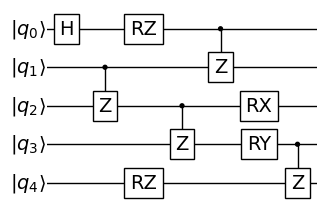

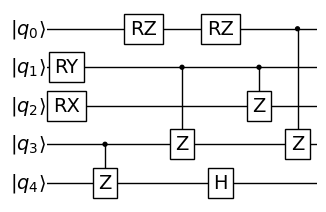

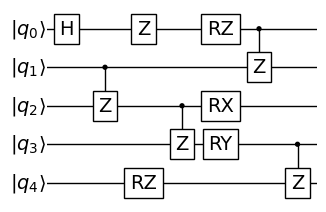

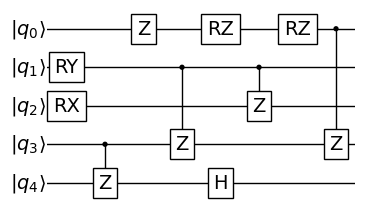

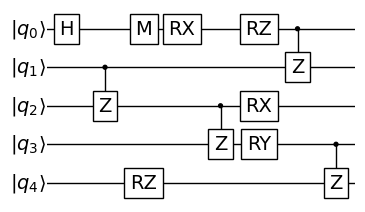

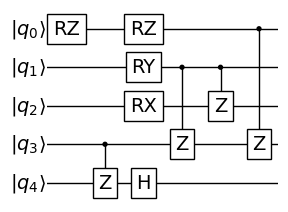

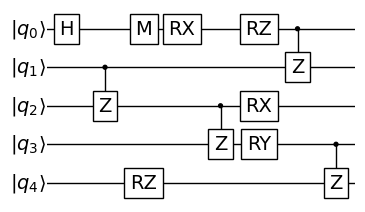

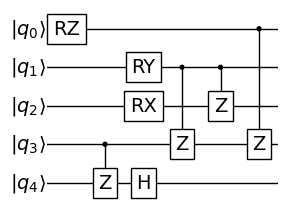

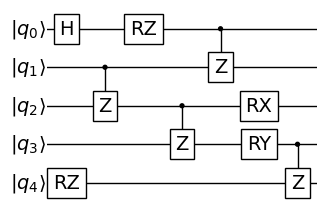

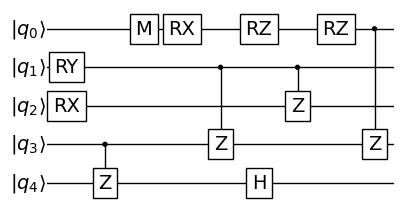

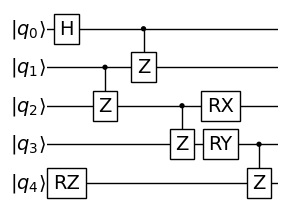

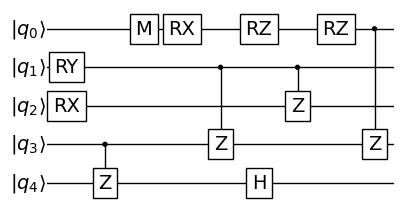

In [12]:
circuit = entire_circuit()

cut = qd.find_cut(circuit)
print(cut)
subcircuits = qd.gate_cutting_subcircuits(circuit, cut, "qibo")

subcircuits = compss_wait_on(subcircuits)

for subcirc in subcircuits:
    # print(subcirc)
    plot_circuit(subcirc, scale=0.5);

### 🧩 8. Wire Cutting with Subcircuits

Same as gate cutting, but uses wire cutting logic.

Subcircuits generated are more complex and may include measurements and resets.

Visuals: Many circuit renderings show various Qiskit circuits built from the wire cut portions.

[('CZ_2', 'RZ_13')]


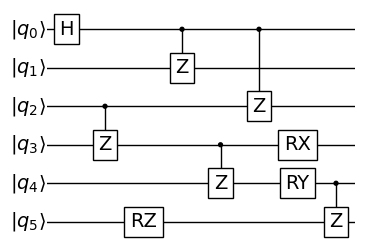

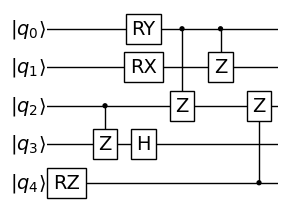

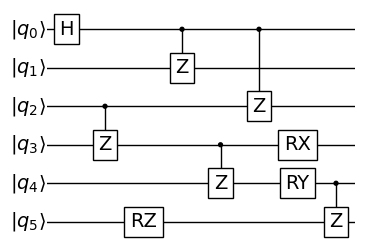

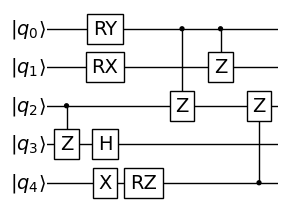

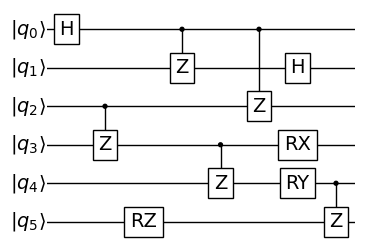

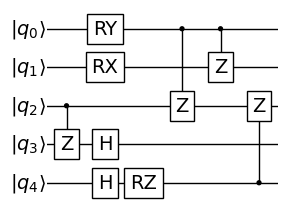

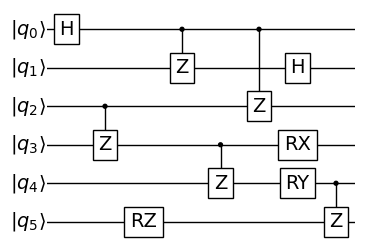

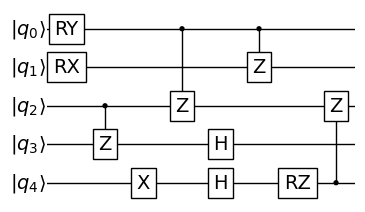

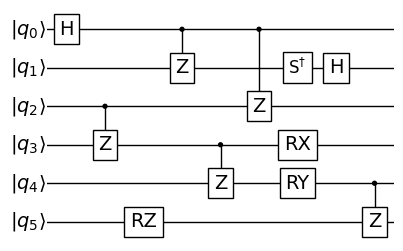

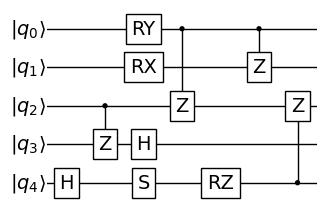

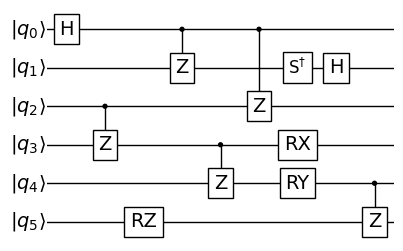

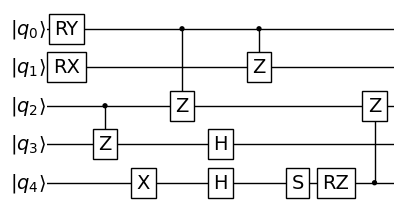

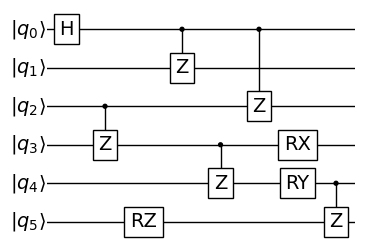

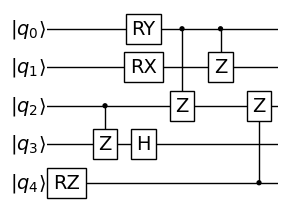

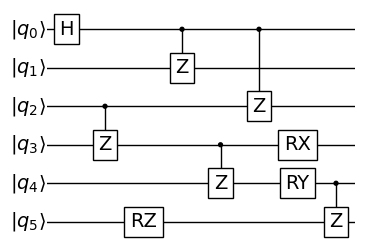

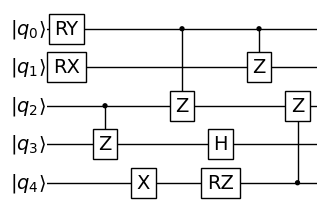

In [13]:
circuit = entire_circuit()

cut = qd.find_cut(circuit, gate_cut=False)
print(cut)
subcircuits = qd.wire_cutting_subcircuits(circuit, cut, "qibo")

subcircuits = compss_wait_on(subcircuits)

for subcirc in subcircuits:
    # print(subcirc)
    plot_circuit(subcirc, scale=0.5);

### ⏹️ 9. Shutting Down PyCOMPSs

ipycompss.stop(sync=True):

* Stops the COMPSs runtime.

* Synchronizes any unresolved futures (e.g., cut, subcircuits).

Why it matters: Proper shutdown is required in PyCOMPSs to finalize all asynchronous tasks cleanly.

In [14]:
ipycompss.stop(sync=True)

********************************************************
***************** STOPPING PyCOMPSs ********************
********************************************************
Checking if any issue happened.
Synchronizing all future objects left on the user scope.
Found a list to synchronize: cut
Found a list to synchronize: subcircuits
********************************************************


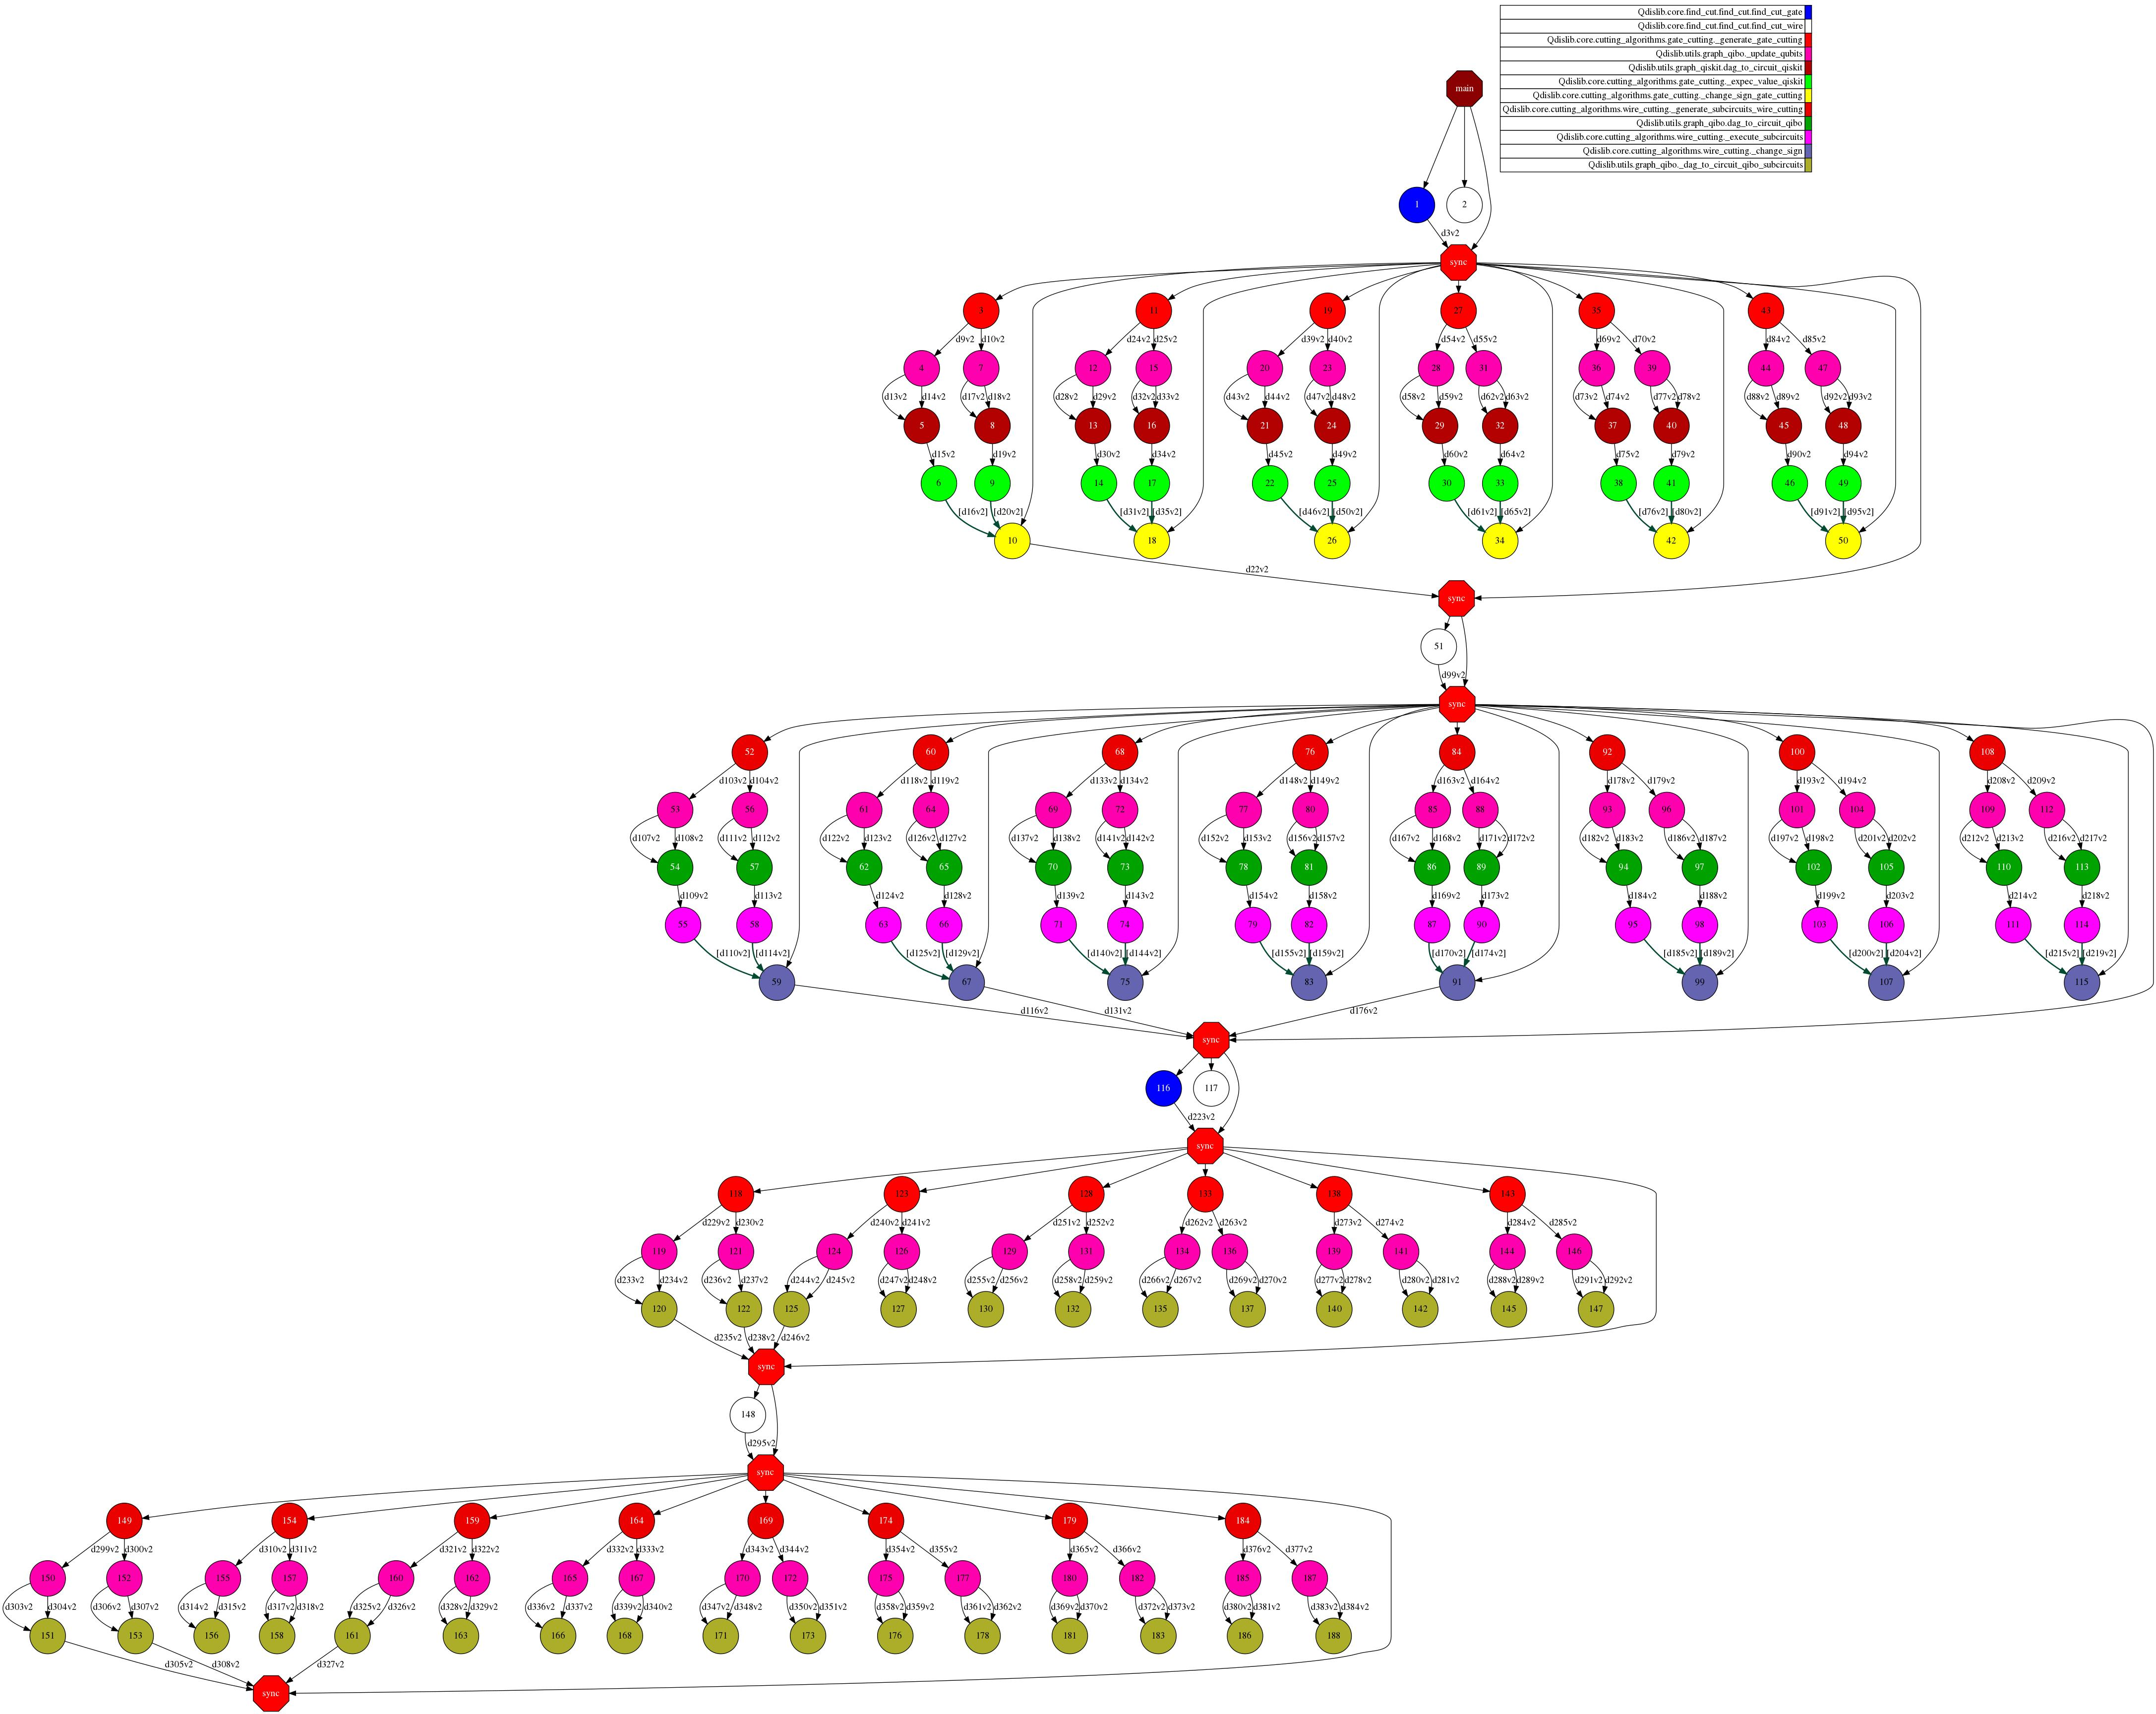

In [15]:
ipycompss.complete_task_graph(fit=True)